## Data Read

In [1]:
import pandas as pd
import numpy as np
import os, json, ast, gc

In [2]:
def read_data(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    try:
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath)
            print(f"file loaded successfully {filepath}")
            return df
        elif filepath.endswith('.json'):
            with open(filepath, 'r', encoding ='utf-8') as f:
            #     df = json.load(f)
                df = [json.loads(line.strip()) for line in f if line.strip()]
            print(f"file loaded successfully {filepath}")
            return df
        elif filepath.endswith('.txt'):
            with open(filepath, 'r', encoding= 'utf-8') as f:
                df = f.readlines()
            print(f"file loaded successfully {filepath}")
            return df
        else:
            raise ValueError(f"File not supported, please provide csv or json: {filepath}")


    except Exception as e:
        raise Exception(f"error loading file {filepath}: {e}")

In [3]:
filepath = 'transactions.json'
content = read_data(filepath)
df = pd.DataFrame(content)
df.head(2)

file loaded successfully transactions.json


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False


## Data Preparation (train-test-validation) (out of time)

In [4]:
df['isFraud'].value_counts(normalize=True)

isFraud
False    0.98421
True     0.01579
Name: proportion, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import pickle
from sklearn.preprocessing import OneHotEncoder as ohe

In [ ]:
def sequential_data_split(df, datetime_col, start_date, end_date):
    # datetime format
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # Sort by datetime
    df = df.sort_values(datetime_col)

    # Convert input dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Define time windows
    train_end = start_date + pd.DateOffset(months=1)
    test_end = train_end + pd.Timedelta(days=15)
    val_end = test_end + pd.Timedelta(days=15)

    # Clip val_end to not exceed dataset end
    val_end = min(val_end, end_date)

    # Split
    train = df[(df[datetime_col] >= start_date) & (df[datetime_col] < train_end)]
    test = df[(df[datetime_col] >= train_end) & (df[datetime_col] < test_end)]
    validation = df[(df[datetime_col] >= test_end) & (df[datetime_col] < val_end)]

    # Summary
    print(f"Train: {train.shape[0]} rows from {start_date.date()} to {train_end.date()}")
    print(f"Test: {test.shape[0]} rows from {train_end.date()} to {test_end.date()}")
    print(f"Validation: {validation.shape[0]} rows from {test_end.date()} to {val_end.date()}")

    # check fraud distribution in each 
    print("Train fraud distribution:", train['isFraud'].value_counts(normalize=True))
    print("Test fraud distribution:", test['isFraud'].value_counts(normalize=True))
    print("Validation fraud distribution:", validation['isFraud'].value_counts(normalize=True))

    return train, test, validation

train, test, validation = sequential_data_split(df, 'transactionDateTime', '2016-11-01', '2016-12-31')


Train: 68097 rows from 2016-11-01 to 2016-12-01
Test: 34354 rows from 2016-12-01 to 2016-12-16
Validation: 34622 rows from 2016-12-16 to 2016-12-31
Train fraud distribution: isFraud
False    0.985917
True     0.014083
Name: proportion, dtype: float64
Test fraud distribution: isFraud
False    0.984078
True     0.015922
Name: proportion, dtype: float64
Validation fraud distribution: isFraud
False    0.98602
True     0.01398
Name: proportion, dtype: float64


## Baseline Model

## Data Transformation (one-hot encoding, etc)

In [ ]:
# Function to prepare data for training to replicate real world data
def transform_data(data, primary_id, target_column, exclude_cols, cat_cols, num_cols, date_cols, is_training=True, encoder_path="onehot_encoder.pkl"):
    
    # Drop unnecessary columns
    data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
    data = data.sort_values(by=['transactionDateTime']).reset_index(drop=True)
    
    # Separate features and target
    X = data.drop(columns=primary_id)
    X = X.drop(columns=exclude_cols, errors='ignore')
    X = X.drop(columns= [target_column], errors='ignore')
    X = X.drop(columns= date_cols, errors='ignore')
    y = data[target_column].astype('int')

#reduce high cardinal categorical columns based on frequency only for columns with unique values >20
    for col in cat_cols:
        if X[col].nunique() > 20:
            # top 20 frequent categories
            top_categories = X[col].value_counts().nlargest(20).index
            # Replace other categories with 'Other'
            X[col] = np.where(X[col].isin(top_categories), X[col], 'Other')
        else:
            # For low cardinality, keep all categories
            pass

# encode categorical features
    if is_training:
        encoder = ohe(drop='first', handle_unknown='ignore')
        X_encoded = encoder.fit_transform(X[cat_cols])
# encoder
        with open(encoder_path, 'wb') as f:
            pickle.dump(encoder, f)
    else:
        with open(encoder_path, 'rb') as f:
            encoder = pickle.load(f)
        X_encoded = encoder.transform(X[cat_cols])

    # Drop original categorical columns and concatenate transformed data
    from scipy import sparse

    # Create DataFrame safely from sparse or dense matrix
    if sparse.issparse(X_encoded):
        X_encoded = X_encoded.toarray()
    X = X.drop(columns=cat_cols)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols), index=X.index)
    X = pd.concat([X, X_encoded_df], axis=1)

    return X, y

    

In [10]:

cat_cols = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode', 'merchantName',
            'transactionType', 'cardPresent', 'expirationDateKeyInMatch','cardCVV', 'enteredCVV', 'cardLast4Digits']
exclude_cols = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 
num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
primary_id = ['accountNumber', 'customerId']
date_cols = ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
target_column = 'isFraud'

Xtrain, ytrain = transform_data(train, primary_id, target_column, exclude_cols, cat_cols, num_cols, date_cols, is_training=True, encoder_path="onehot_encoder.pkl")
Xtest, ytest = transform_data(test, primary_id, target_column, exclude_cols, cat_cols, num_cols,date_cols, is_training=False, encoder_path="onehot_encoder.pkl")

c:\Users\HIMANSHU\anaconda3\envs\vecdb\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [5, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [11]:
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)
Xtrain.head(5)

(68097, 123) (68097,)
(34354, 123) (34354,)


,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,...,cardLast4Digits_619,cardLast4Digits_6580,cardLast4Digits_6674,cardLast4Digits_7629,cardLast4Digits_8208,cardLast4Digits_8332,cardLast4Digits_8502,cardLast4Digits_9311,cardLast4Digits_9581,cardLast4Digits_Other
0,1000.0,967.77,229.79,32.23,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,15000.0,1786.67,26.77,13213.33,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7500.0,7500.00,0.64,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,15000.0,1004.51,169.48,13995.49,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,15000.0,2654.69,381.83,12345.31,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
Xtest.head(5)

,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry_CAN,acqCountry_MEX,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,...,cardLast4Digits_619,cardLast4Digits_6580,cardLast4Digits_6674,cardLast4Digits_7629,cardLast4Digits_8208,cardLast4Digits_8332,cardLast4Digits_8502,cardLast4Digits_9311,cardLast4Digits_9581,cardLast4Digits_Other
0,50000.0,50000.00,2.38,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5000.0,3064.32,40.76,1935.68,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,500.0,176.46,9.46,323.54,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,250.0,250.00,49.63,0.00,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,15000.0,6396.69,245.58,8603.31,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Baseline Model training

[0]	train-aucpr:0.05622	test-aucpr:0.05087
[10]	train-aucpr:0.08359	test-aucpr:0.06748
[20]	train-aucpr:0.08542	test-aucpr:0.06605
[30]	train-aucpr:0.09192	test-aucpr:0.06794
[40]	train-aucpr:0.09611	test-aucpr:0.06783
[50]	train-aucpr:0.09886	test-aucpr:0.06678
[52]	train-aucpr:0.09978	test-aucpr:0.06730


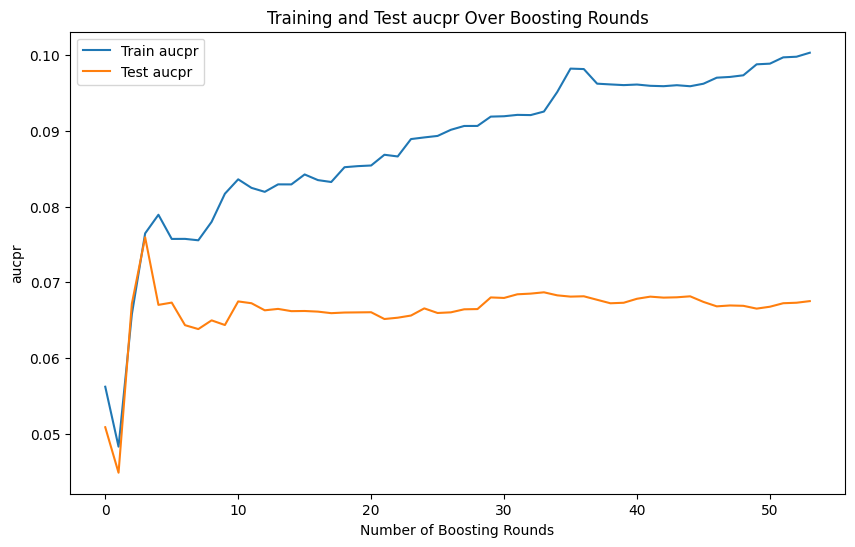

best threshold for aucpr is: 0.7379983
Train Accuracy: 0.9503
Test Accuracy: 0.9478
Train ROC AUC: 0.8336
Test ROC AUC: 0.7691

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     33807
           1       0.08      0.22      0.12       547

    accuracy                           0.95     34354
   macro avg       0.53      0.59      0.55     34354
weighted avg       0.97      0.95      0.96     34354



In [ ]:
import matplotlib.pyplot as plt
#accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
def train_xgboost(Xtrain,ytrain, Xtest,ytest, params, early_stopping_rounds=50):
    """
    Train an XGBoost model on the given dataset with hyperparameter tuning and early stopping.
    """

    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(Xtrain, label=ytrain)
    dtest = xgb.DMatrix(Xtest, label=ytest)

    params = params

    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
        verbose_eval=10
    )

    # evaluation metric
    eval_metric = params['eval_metric']
    train_loss = evals_result['train'][eval_metric]
    test_loss = evals_result['test'][eval_metric]

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label=f'Train {eval_metric}')
    plt.plot(test_loss, label=f'Test {eval_metric}')
    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel(params['eval_metric'])
    plt.title(f'Training and Test {eval_metric} Over Boosting Rounds')
    plt.legend()
    plt.show()

    # Predict on train and test sets
    y_train_pred = model.predict(dtrain)
    y_test_pred = model.predict(dtest)

    if eval_metric=='logloss' or eval_metric=='auc':
    # Find best threshold using ROC curve
        fpr, tpr, thresholds = roc_curve(ytest, y_test_pred)
        j_scores = tpr - fpr
        best_threshold = thresholds[np.argmax(j_scores)]
        print(f"best threshold for {eval_metric} is:", best_threshold)
    
    # Find best threshold using pr curve
    elif eval_metric == 'aucpr':
        precision, recall, thresholds = precision_recall_curve(ytest, y_test_pred)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # add small value to avoid divide by zero
        best_index = np.argmax(f1_scores)
        best_threshold = thresholds[best_index]
        print(f"best threshold for {eval_metric} is:", best_threshold)

    # Convert probabilities to binary using best threshold
    y_test_pred_binary = [1 if p > best_threshold else 0 for p in y_test_pred]
    y_train_pred_binary = [1 if p > best_threshold else 0 for p in y_train_pred]

    # Calculate accuracy and ROC AUC for train and test sets
    train_accuracy = accuracy_score(ytrain, y_train_pred_binary)
    test_accuracy = accuracy_score(ytest, y_test_pred_binary)

    train_roc_auc = roc_auc_score(ytrain, y_train_pred)
    test_roc_auc = roc_auc_score(ytest, y_test_pred)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print("\nClassification Report (Test):")
    print(classification_report(ytest, y_test_pred_binary))

    return model, best_threshold

scale_pos_weight = ytrain.shape[0] / ytrain.sum() - 1
params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'max_depth': 5,  
        'eta': 0.05,  
        'gamma': 0.1,  
        'min_child_weight': 5,  
        'subsample': 0.7,  
        'colsample_bytree': 0.7,
        'scale_pos_weight': scale_pos_weight,  # scale_pos_weight = 0.98481 / 0.01519 ≈ 64.83
        'seed': 50
    }
model, best_threshold = train_xgboost(Xtrain, ytrain, Xtest, ytest, params, early_stopping_rounds=50)


In [31]:
# del model
gc.collect()

3814

## Baseline Model evaluation (at different threshold)

c:\Users\HIMANSHU\anaconda3\envs\vecdb\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   Threshold  Accuracy  Precision    Recall  F1-score   ROC-AUC
0        0.1  0.091460   0.017223  1.000000  0.033864  0.769056
1        0.2  0.143477   0.018250  1.000000  0.035847  0.769056
2        0.3  0.311376   0.021453  0.946984  0.041955  0.769056
3        0.4  0.634802   0.031838  0.745887  0.061069  0.769056
4        0.5  0.796385   0.045788  0.594150  0.085023  0.769056
5        0.6  0.864179   0.056811  0.482633  0.101656  0.769056
6        0.7  0.919340   0.064605  0.301645  0.106417  0.769056
7        0.8  0.976829   0.102236  0.058501  0.074419  0.769056
8        0.9  0.984078   0.000000  0.000000  0.000000  0.769056


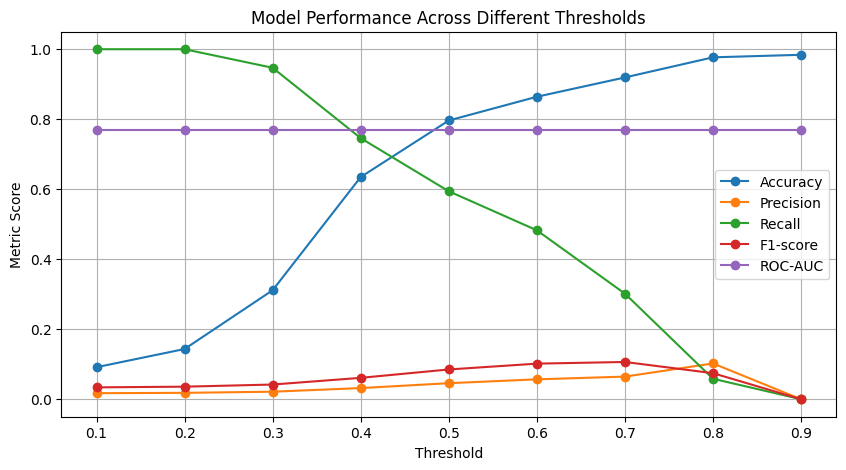

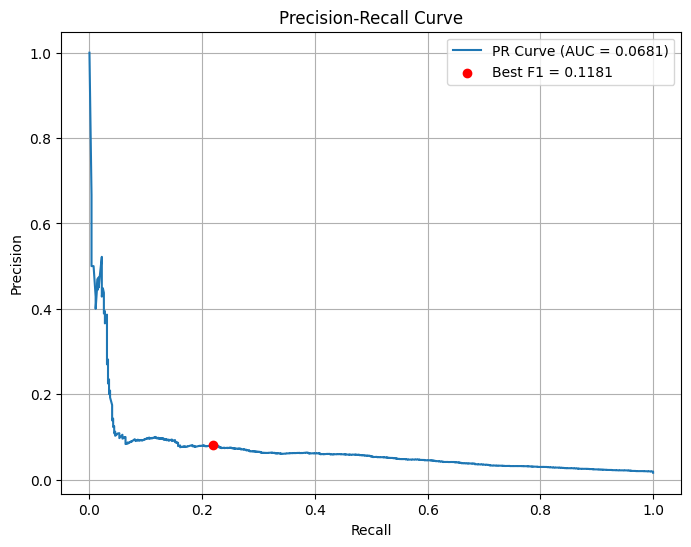

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc

def evaluate_thresholds(model, X_test, y_test):
    """
    Evaluate classification metrics across various thresholds and plot performance, including PR curve.
    """
    y_pred_probs = model.predict(xgb.DMatrix(X_test))  # Get probabilities
    thresholds = np.arange(0.1, 1.0, 0.1)  # Thresholds from 0.1 to 0.9

    results = []
    for threshold in thresholds:
        y_pred_binary = [1 if p > threshold else 0 for p in y_pred_probs]

        # Compute classification metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
        accuracy = (y_test == y_pred_binary).mean()
        roc_auc = roc_auc_score(y_test, y_pred_probs)

        results.append((threshold, accuracy, precision, recall, f1, roc_auc))

    # Convert to DataFrame for better readability
    results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])

    # Print table
    print(results_df)

    # Plot metrics vs thresholds
    results_df.set_index('Threshold')[['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']].plot(
        figsize=(10, 5), marker='o', grid=True)
    plt.title("Model Performance Across Different Thresholds")
    plt.ylabel("Metric Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')
    plt.show()

    # Plot PR Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_probs)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    best_f1_index = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_index]

    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {auc(recall_curve, precision_curve):.4f})')
    plt.scatter(recall_curve[best_f1_index], precision_curve[best_f1_index],
                color='red', label=f'Best F1 = {best_f1:.4f}', zorder=5)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.show()

    return results_df

results_df = evaluate_thresholds(model, Xtest, ytest)


## Feature importance

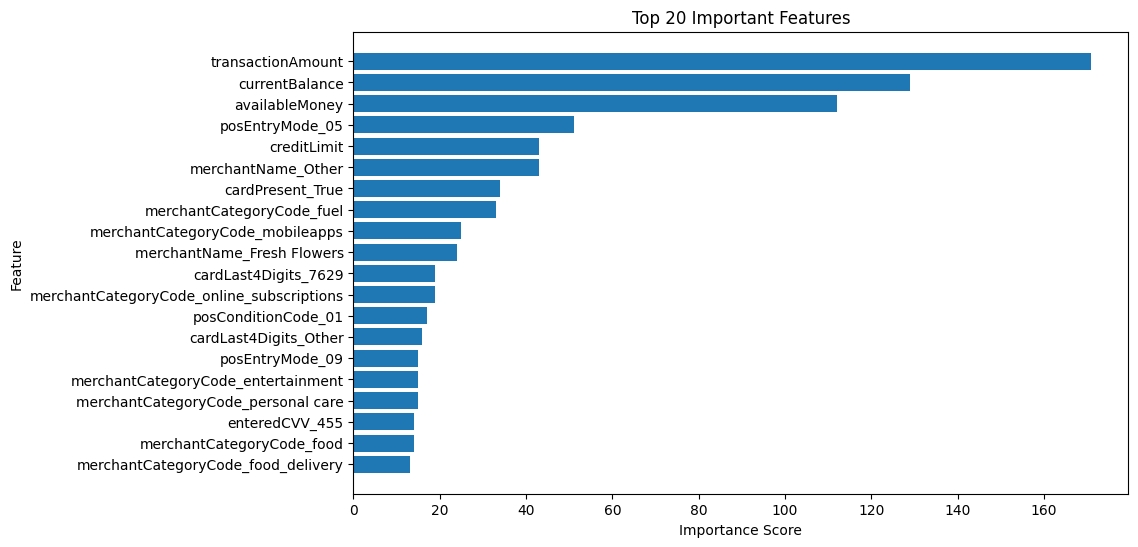

In [33]:
def plot_feature_importance(model, top_n=20):
    """
    Plots the top N most important features from an XGBoost model.

    Parameters:
        model: Trained XGBoost model
        top_n: Number of top features to plot (default=20)
    """
    importance = model.get_score(importance_type='weight')
    importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Important Features')
    plt.gca().invert_yaxis()
    plt.show()

# Usage Example
plot_feature_importance(model, top_n=20)

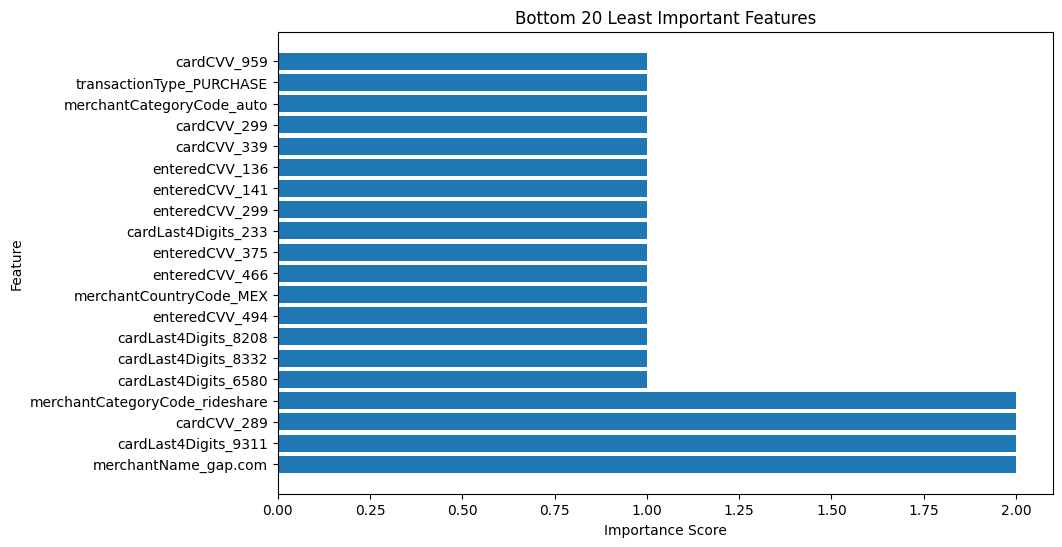

In [40]:
def plot_least_important_features(model, bottom_n=20):
    """
    Plots the bottom N least important features from an XGBoost model.

    Parameters:
        model: Trained XGBoost model
        bottom_n: Number of bottom features to plot (default=20)
    """
    importance = model.get_score(importance_type='weight')
    importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
    importance_df = importance_df.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:bottom_n], importance_df['Importance'][:bottom_n])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Bottom {bottom_n} Least Important Features')
    plt.gca().invert_yaxis()
    plt.show()

# Usage Example
plot_least_important_features(model, bottom_n=20)


In [34]:
##
import pickle
with open ('model_baseline.pkl', 'wb') as f:
    pickle.dump(model, f)

## Model improvements

## Feature Engineering

In [7]:
def create_features(df):
    df = df.copy()

    # Ensure datetime format
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], errors='coerce')
    df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%m/%Y')
    df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])

    # -------------------- DATETIME FEATURES --------------------
    df['hour'] = df['transactionDateTime'].dt.hour
    df['day'] = df['transactionDateTime'].dt.day
    df['weekday'] = df['transactionDateTime'].dt.weekday
    # df['month'] = df['transactionDateTime'].dt.month
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    df['is_night'] = df['hour'].isin([0,1,2,3,4,5]).astype(int)
    # Account age at time of transaction
    df['accountAgeDays'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
    # # Days since last address change at transaction time
    df['daysSinceAddressChange'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
    # # Days until card expiration at transaction time
    df['daysUntilExpiration'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days

    # -------------------- x-border when aq is not same as merch country --------------------
    df['is_x_border'] = np.where((df['acqCountry'] != df['merchantCountryCode']) & (df['acqCountry']!="") & (df['merchantCountryCode']!=""), 1,0)

    # -------------------- VELOCITY FEATURES --------------------
    # Transactions per account in last 1/6/24 hours
    df = df.sort_values(['accountNumber', 'transactionDateTime'])
    
    for hrs in [1, 6, 24]:
        count_col = f'txn_count_{hrs}hr'
        sum_col = f'amt_sum_{hrs}hr'
        ratio_col = f'amt_vs_avg_{hrs}hr'

        def txn_count_and_sum_last_n_hours(group):
            group = group.sort_values('transactionDateTime')
            counts = []
            sums = []

            for idx in range(len(group)):
                current_time = group.iloc[idx]['transactionDateTime']
                window_start = current_time - pd.Timedelta(hours=hrs)
                window = group[(group['transactionDateTime'] >= window_start) & (group['transactionDateTime'] < current_time)]

                counts.append(window.shape[0])
                sums.append(window['transactionAmount'].sum())

            return pd.DataFrame({
                count_col: counts,
                sum_col: sums
            }, index=group.index)

        result = (
            df.groupby('accountNumber')
            .apply(txn_count_and_sum_last_n_hours)
            .reset_index(level=0, drop=True)
        )

        # Assign results to original df
        df[count_col] = result[count_col]
        df[sum_col] = result[sum_col]
        df[ratio_col] = df['transactionAmount'] / (df[sum_col] + 1e-6)



    # -------------------- Behavioral Inconsistencies --------------------
    # Amount stats per user per day
    df['transactionDate'] = df['transactionDateTime'].dt.date
    daily_amt = df.groupby(['accountNumber', 'transactionDate'])['transactionAmount'].agg(['mean', 'sum', 'count']).reset_index()
    daily_amt.columns = ['accountNumber', 'transactionDate', 'daily_avg_amt', 'daily_total_amt', 'daily_txn_count']
    df = pd.merge(df, daily_amt, on=['accountNumber', 'transactionDate'], how='left')

    # Z-score relative to user's historical amounts
    df['user_amt_zscore'] = df.groupby('accountNumber')['transactionAmount'].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    # Flag transactions > 3 standard deviations
    df['amt_outlier'] = np.where(df['user_amt_zscore'] > 3, 1,0)


    # -------------------- TIME SINCE LAST TXN --------------------
    df['time_since_last_txn'] = (
        df.groupby('accountNumber')['transactionDateTime']
        .diff().dt.total_seconds().fillna(-1)
    )
    # Time since last txn of the same merchant (fraudsters reuse merchants)
    df['time_since_same_merchant'] = (
        df.groupby(['accountNumber', 'merchantName'])['transactionDateTime']
        .diff().dt.total_seconds().fillna(-1)
    )

    # New merchant for the user (never seen before)
    df['is_new_merchant'] = (
        df.groupby('accountNumber')['merchantName']
        .transform(lambda x: ~x.duplicated(keep='first')).astype(int)
    )

    # -------------------- REPEATED AMOUNTS (possible automation/fraud) ---
    df['is_repeated_amount'] = (
        df.groupby('accountNumber')['transactionAmount']
        .transform(lambda x: x.duplicated(keep=False).astype(int))
    )

    # -------------------- MERCHANT BEHAVIOUR (RARITY SCORE) --------------------
    # rare merchantName may be linked to fraud
    merchant_freq = df['merchantName'].value_counts(normalize=True)
    df['merchant_rarity'] = df['merchantName'].map(merchant_freq)
    df['merchant_rarity'] = df['merchant_rarity'].fillna(0)
    df['is_rare_merchant'] = (df['merchant_rarity'] < 0.001).astype(int)  # tweak threshold

    # -------------------- MATCHING AMOUNT + MERCHANT REPEAT (reversals, duplicates etc.) ---
    group_cols = ['accountNumber', 'merchantName', 'transactionAmount']
    repeated_txns = df.groupby(group_cols).size().reset_index(name='same_txn_count')
    df = pd.merge(df, repeated_txns, on=group_cols, how='left')


    # -------------------- ACCOUNT USAGE PATTERN --------------------
    df['used_credit_ratio'] = (df['creditLimit'] - df['availableMoney']) / df['creditLimit']
    df['balance_ratio'] = df['currentBalance'] / df['creditLimit']

    # --------------------ACCOUNT SEGMENT --------------------
    bins = [0, 10000, 15000, 20000, float('inf')]
    labels = ['lessthan10k', '10to15k', '15to20k', 'greaterthan20k']
    df['credit_segment'] = pd.cut(df['creditLimit'], bins=bins, labels=labels, right=False)


    # Cleanup temp columns
    df.drop(columns=['transactionDate'], inplace=True)

    return df



In [8]:
train_f = create_features(train)
test_f = create_features(test)
print(f"train shape--> {test.shape}", f"train shape after features --> {train_f.shape}")
print(f"test shape--> {test.shape}", f"test shape after features --> {test_f.shape}")
train_f.head(2)

C:\Users\HIMANSHU\AppData\Local\Temp\ipykernel_1488\2190500571.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('accountNumber')
C:\Users\HIMANSHU\AppData\Local\Temp\ipykernel_1488\2190500571.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('accountNumber')
C:\Users\HIMANSHU\AppData\Local\Temp\ipykernel_1488\2190500571.py:55: DeprecationWarning: DataFrameGroupBy.apply operated 

train shape--> (34354, 29) train shape after features --> (68097, 62)
test shape--> (34354, 29) test shape after features --> (34354, 62)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,time_since_last_txn,time_since_same_merchant,is_new_merchant,is_repeated_amount,merchant_rarity,is_rare_merchant,same_txn_count,used_credit_ratio,balance_ratio,credit_segment
0,100088067,100088067,50000.0,50000.00,2016-11-05 03:55:37,6.32,Mobile eCards,US,US,09,...,-1.0,-1.0,1,0,0.009340,0,1,0.000000,0.000000,greaterthan20k
1,100088067,100088067,50000.0,49993.68,2016-11-06 10:49:52,3.96,Apple iTunes,US,US,09,...,111255.0,-1.0,1,0,0.015434,0,1,0.000126,0.000126,greaterthan20k


In [9]:
train_f.to_parquet("train_f.parquet", index=False)
test_f.to_parquet("test_f.parquet", index=False)
additional_cols = set(train_f.columns)-set(train.columns)
print("additional columns in train_f compared to train:", len(additional_cols))
print(additional_cols)
# del df
gc.collect()

additional columns in train_f compared to train: 33
{'amt_sum_6hr', 'is_new_merchant', 'time_since_same_merchant', 'daysSinceAddressChange', 'day', 'is_rare_merchant', 'time_since_last_txn', 'is_repeated_amount', 'txn_count_6hr', 'same_txn_count', 'txn_count_24hr', 'credit_segment', 'daily_txn_count', 'used_credit_ratio', 'is_night', 'amt_sum_1hr', 'user_amt_zscore', 'hour', 'daily_avg_amt', 'txn_count_1hr', 'accountAgeDays', 'daysUntilExpiration', 'is_weekend', 'daily_total_amt', 'amt_vs_avg_6hr', 'weekday', 'amt_outlier', 'is_x_border', 'amt_vs_avg_24hr', 'merchant_rarity', 'amt_sum_24hr', 'amt_vs_avg_1hr', 'balance_ratio'}


0

## Feature transformation (one hot encoding, etc)

In [11]:
# Function to prepare data for training to replicate real world data
def transform_data(data, primary_id, target_column, exclude_cols, cat_cols, num_cols, date_cols, is_training=True, encoder_path="onehot_encoder_v2.pkl"):
    
    # Feature engineering done

    # Drop unnecessary columns
    # Separate features and target
    X = data.drop(columns=primary_id)
    X = X.drop(columns=exclude_cols, errors='ignore')
    X = X.drop(columns= [target_column], errors='ignore')
    X = X.drop(columns= date_cols, errors='ignore')
    y = data[target_column].astype('int')

    #reduce high cardinal categorical columns based on frequency only for columns with unique values >20
    # Ensure categorical values are clean
    # X[cat_cols] = X[cat_cols].fillna('Unknown').astype(str)
    X[cat_cols] = X[cat_cols].astype(str)
    for col in cat_cols:
        if X[col].nunique() > 100:
            # Get the top 10 frequent categories
            top_categories = X[col].value_counts().nlargest(100).index
            # Replace other categories with 'Other'
            X[col] = np.where(X[col].isin(top_categories), X[col], 'Other')
        else:
            # For low cardinality, keep all categories
            pass

    # encode categorical features
    if is_training:
        encoder = ohe(drop='first', handle_unknown='ignore')
        X_encoded = encoder.fit_transform(X[cat_cols])
        # Save the encoder for future use
        with open(encoder_path, 'wb') as f:
            pickle.dump(encoder, f)
    else:
        # Load the encoder
        with open(encoder_path, 'rb') as f:
            encoder = pickle.load(f)
        X_encoded = encoder.transform(X[cat_cols])

    # Drop original categorical columns and concatenate transformed data
    from scipy import sparse

    # Create DataFrame safely from sparse or dense matrix
    if sparse.issparse(X_encoded):
        X_encoded = X_encoded.toarray()
    X = X.drop(columns=cat_cols)
    X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols), index=X.index)
    X = pd.concat([X, X_encoded_df], axis=1)


    return X, y


cat_cols = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode', 'merchantName',
            'transactionType', 'cardPresent', 'expirationDateKeyInMatch','cardCVV', 'enteredCVV', 'cardLast4Digits'] +   ['day', 'credit_segment',
                            'hour', 'is_night', 'is_rare_merchant', 'is_new_merchant', 'is_repeated_amount', 'is_weekend', 'is_x_border', 'weekday']

exclude_cols = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] 

num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'] + ['daily_avg_amt',  
'accountAgeDays', 'amt_vs_avg_6hr',  'daysSinceAddressChange', 'daily_txn_count', 
 'merchant_rarity', 'amt_vs_avg_24hr', 'used_credit_ratio', 'txn_count_6hr', 'amt_vs_avg_1hr', 
'daily_total_amt', 'time_since_last_txn', 'balance_ratio', 'txn_count_1hr', 'daysUntilExpiration', 
 'amt_outlier', 'amt_sum_1hr', 'txn_count_24hr', 'amt_sum_6hr', 'same_txn_count', 'user_amt_zscore', 
'amt_sum_24hr', 'time_since_same_merchant']

primary_id = ['accountNumber', 'customerId']
date_cols = ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
target_column = 'isFraud'
print(len(cat_cols+exclude_cols+num_cols+primary_id+date_cols+[target_column]))
Xtrain, ytrain = transform_data(train_f, primary_id, target_column, exclude_cols, cat_cols, num_cols, date_cols, is_training=True, encoder_path="ohe_xgb_feft.pkl")
Xtest, ytest = transform_data(test_f, primary_id, target_column, exclude_cols, cat_cols, num_cols,date_cols, is_training=False, encoder_path="ohe_xgb_feft.pkl") 

62


c:\Users\HIMANSHU\anaconda3\envs\vecdb\lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [5, 9, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)
Xtrain.head(5)

(68097, 533) (68097,)
(34354, 533) (34354,)


,creditLimit,availableMoney,transactionAmount,currentBalance,accountAgeDays,daysSinceAddressChange,daysUntilExpiration,txn_count_1hr,amt_sum_1hr,amt_vs_avg_1hr,...,is_new_merchant_1,is_repeated_amount_1,is_weekend_1,is_x_border_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,50000.0,50000.00,6.32,0.00,1031,1031,3859,0,0.0,6320000.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,50000.0,49993.68,3.96,6.32,1032,1032,6080,0,0.0,3960000.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,50000.0,49989.72,60.41,10.28,1033,1033,4131,0,0.0,60410000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50000.0,49929.31,95.11,70.69,1035,1035,1603,0,0.0,95110000.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,50000.0,49834.20,22.32,165.80,1046,1046,1288,0,0.0,22320000.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


[0]	train-aucpr:0.04768	test-aucpr:0.04514
[10]	train-aucpr:0.08253	test-aucpr:0.05368
[20]	train-aucpr:0.09152	test-aucpr:0.06822
[30]	train-aucpr:0.09795	test-aucpr:0.06019
[40]	train-aucpr:0.11028	test-aucpr:0.05616
[50]	train-aucpr:0.11742	test-aucpr:0.06157
[60]	train-aucpr:0.12526	test-aucpr:0.06017
[70]	train-aucpr:0.13480	test-aucpr:0.06783
[80]	train-aucpr:0.14269	test-aucpr:0.06882
[90]	train-aucpr:0.14940	test-aucpr:0.06793
[100]	train-aucpr:0.15556	test-aucpr:0.06837
[110]	train-aucpr:0.16302	test-aucpr:0.06889
[120]	train-aucpr:0.17082	test-aucpr:0.06994
[130]	train-aucpr:0.18083	test-aucpr:0.06866
[140]	train-aucpr:0.18597	test-aucpr:0.06852
[150]	train-aucpr:0.19274	test-aucpr:0.06884
[160]	train-aucpr:0.20682	test-aucpr:0.06929
[170]	train-aucpr:0.21265	test-aucpr:0.06954
[180]	train-aucpr:0.22061	test-aucpr:0.06950
[190]	train-aucpr:0.22729	test-aucpr:0.06968
[200]	train-aucpr:0.23550	test-aucpr:0.06975
[210]	train-aucpr:0.24824	test-aucpr:0.06882
[220]	train-aucpr:0.2

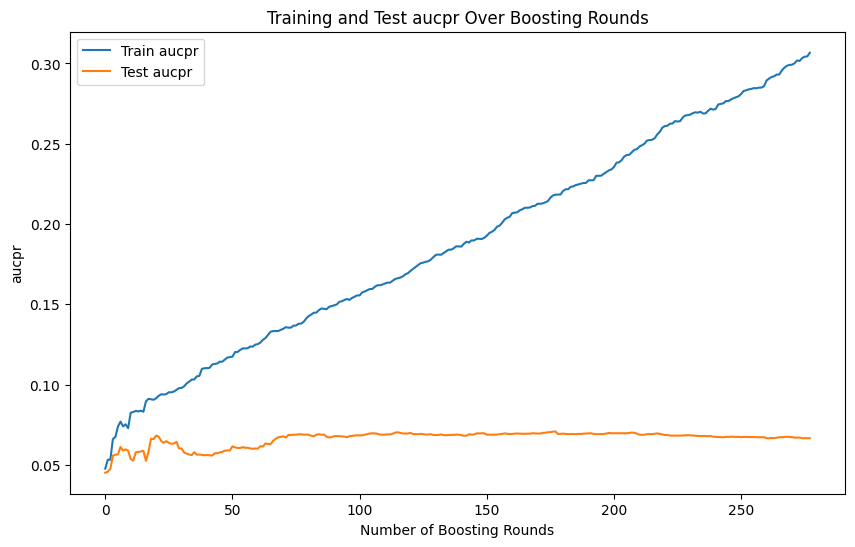

best threshold for aucpr is: 0.72134835
Train Accuracy: 0.9609
Test Accuracy: 0.9509
Train ROC AUC: 0.9594
Test ROC AUC: 0.7793

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     33807
           1       0.09      0.23      0.13       547

    accuracy                           0.95     34354
   macro avg       0.54      0.60      0.55     34354
weighted avg       0.97      0.95      0.96     34354



In [15]:
import matplotlib.pyplot as plt
#accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb
def train_xgboost(Xtrain,ytrain, Xtest,ytest, params, early_stopping_rounds=50):
    """
    Train an XGBoost model on the given dataset with hyperparameter tuning and early stopping.
    """

    # Convert data to DMatrix format
    dtrain = xgb.DMatrix(Xtrain, label=ytrain)
    dtest = xgb.DMatrix(Xtest, label=ytest)

    # Set XGBoost parameters with the best parameters
    params = params

    # Train the model with early stopping
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
        verbose_eval=10
    )

    # Extract the log loss from the evaluation results
    eval_metric = params['eval_metric']
    train_loss = evals_result['train'][eval_metric]
    test_loss = evals_result['test'][eval_metric]

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label=f'Train {eval_metric}')
    plt.plot(test_loss, label=f'Test {eval_metric}')
    plt.xlabel('Number of Boosting Rounds')
    plt.ylabel(params['eval_metric'])
    plt.title(f'Training and Test {eval_metric} Over Boosting Rounds')
    plt.legend()
    plt.show()

    # Predict on train and test sets
    y_train_pred = model.predict(dtrain)
    y_test_pred = model.predict(dtest)

    if eval_metric=='logloss' or eval_metric=='auc':
    # Find best threshold using ROC curve
        fpr, tpr, thresholds = roc_curve(ytest, y_test_pred)
        j_scores = tpr - fpr
        best_threshold = thresholds[np.argmax(j_scores)]
        print(f"best threshold for {eval_metric} is:", best_threshold)

    elif eval_metric == 'aucpr':
        precision, recall, thresholds = precision_recall_curve(ytest, y_test_pred)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # add small value to avoid divide by zero
        best_index = np.argmax(f1_scores)
        best_threshold = thresholds[best_index]
        print(f"best threshold for {eval_metric} is:", best_threshold)

    # Convert probabilities to binary using best threshold
    y_test_pred_binary = [1 if p > best_threshold else 0 for p in y_test_pred]
    y_train_pred_binary = [1 if p > best_threshold else 0 for p in y_train_pred]

    # Calculate accuracy and ROC AUC for train and test sets
    train_accuracy = accuracy_score(ytrain, y_train_pred_binary)
    test_accuracy = accuracy_score(ytest, y_test_pred_binary)

    train_roc_auc = roc_auc_score(ytrain, y_train_pred)
    test_roc_auc = roc_auc_score(ytest, y_test_pred)

    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train ROC AUC: {train_roc_auc:.4f}")
    print(f"Test ROC AUC: {test_roc_auc:.4f}")
    print("\nClassification Report (Test):")
    print(classification_report(ytest, y_test_pred_binary))

    return model, best_threshold

scale_pos_weight = ytrain.shape[0] / ytrain.sum() - 1
params = {
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',
        'max_depth': 5,  
        'eta': 0.05,  
        'gamma': 0.1,  
        'min_child_weight': 5,  
        'subsample': 0.7,  
        'colsample_bytree': 0.7,
        'scale_pos_weight': scale_pos_weight,  # scale_pos_weight = 0.98481 / 0.01519 ≈ 64.83
        'seed': 50
    }
model, best_threshold = train_xgboost(Xtrain, ytrain, Xtest, ytest, params, early_stopping_rounds=100)


In [16]:
import pickle
with open('model_xgb_fe_ft.pkl', 'wb') as f:
    pickle.dump(model, f)

## model performance

   Threshold  Accuracy  Precision    Recall  F1-score   ROC-AUC
0        0.1  0.233219   0.019950  0.979890  0.039104  0.779285
1        0.2  0.466350   0.026010  0.892139  0.050546  0.779285
2        0.3  0.660360   0.034179  0.745887  0.065364  0.779285
3        0.4  0.784188   0.044568  0.614260  0.083107  0.779285
4        0.5  0.857658   0.053649  0.477148  0.096452  0.779285
5        0.6  0.904407   0.062919  0.360146  0.107123  0.779285
6        0.7  0.943093   0.081948  0.252285  0.123711  0.779285
7        0.8  0.973162   0.106918  0.093236  0.099609  0.779285
8        0.9  0.983816   0.354839  0.020110  0.038062  0.779285


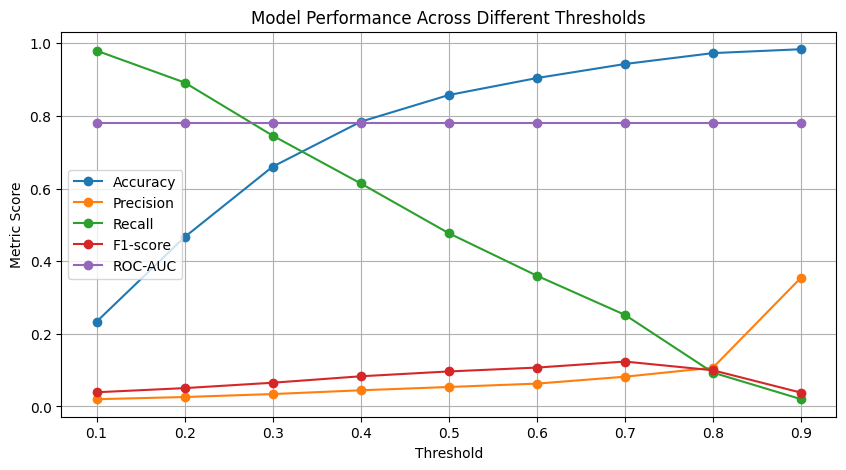

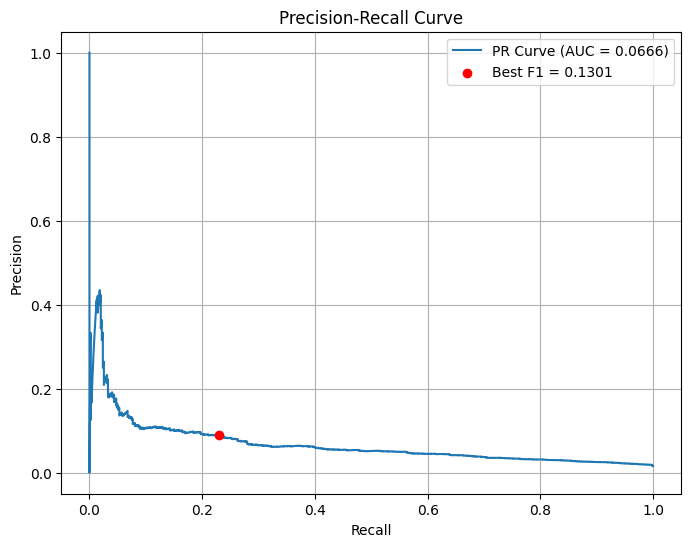

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc

def evaluate_thresholds(model, X_test, y_test):
    """
    Evaluate classification metrics across various thresholds and plot performance, including PR curve.
    """
    y_pred_probs = model.predict(xgb.DMatrix(X_test))  # Get probabilities
    thresholds = np.arange(0.1, 1.0, 0.1)  # Thresholds from 0.1 to 0.9

    results = []
    for threshold in thresholds:
        y_pred_binary = [1 if p > threshold else 0 for p in y_pred_probs]

        # Compute classification metrics
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average='binary')
        accuracy = (y_test == y_pred_binary).mean()
        roc_auc = roc_auc_score(y_test, y_pred_probs)

        results.append((threshold, accuracy, precision, recall, f1, roc_auc))

    # Convert to DataFrame for better readability
    results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])

    # Print table
    print(results_df)

    # Plot metrics vs thresholds
    results_df.set_index('Threshold')[['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']].plot(
        figsize=(10, 5), marker='o', grid=True)
    plt.title("Model Performance Across Different Thresholds")
    plt.ylabel("Metric Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')
    plt.show()

    # Plot PR Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_probs)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    best_f1_index = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_index]

    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {auc(recall_curve, precision_curve):.4f})')
    plt.scatter(recall_curve[best_f1_index], precision_curve[best_f1_index],
                color='red', label=f'Best F1 = {best_f1:.4f}', zorder=5)
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.show()

    return results_df

results_df = evaluate_thresholds(model, Xtest, ytest)


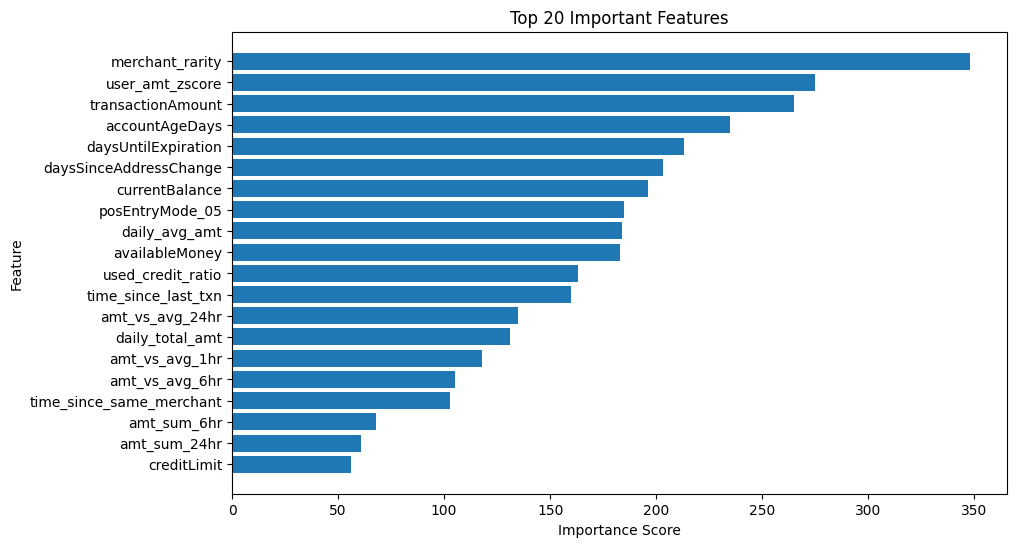

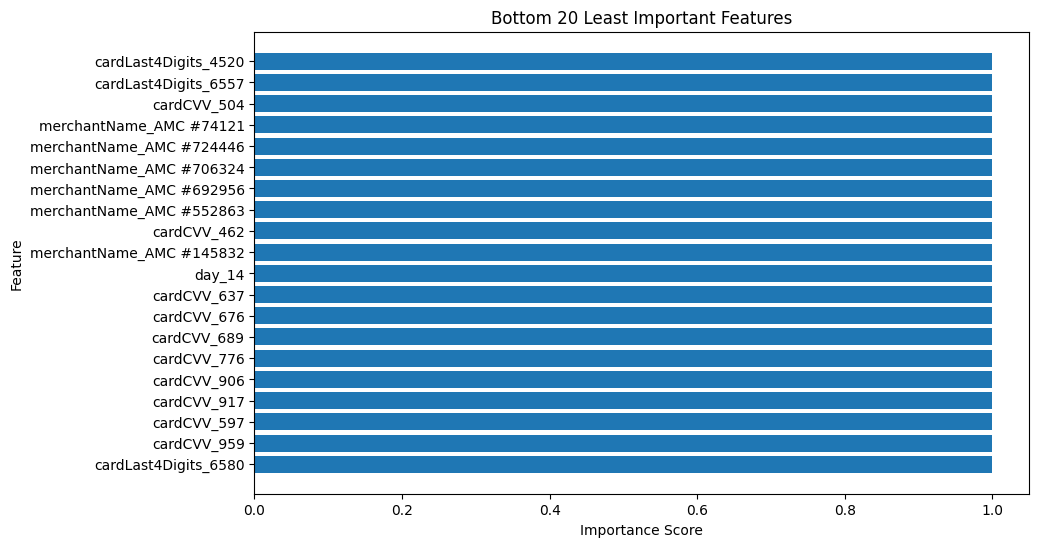

In [18]:
def plot_feature_importance(model, top_n=20):
    """
    Plots the top N most important features from an XGBoost model.

    Parameters:
        model: Trained XGBoost model
        top_n: Number of top features to plot (default=20)
    """
    importance = model.get_score(importance_type='weight')
    importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:top_n], importance_df['Importance'][:top_n])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Important Features')
    plt.gca().invert_yaxis()
    plt.show()

def plot_least_important_features(model, bottom_n=20):
    """
    Plots the bottom N least important features from an XGBoost model.

    Parameters:
        model: Trained XGBoost model
        bottom_n: Number of bottom features to plot (default=20)
    """
    importance = model.get_score(importance_type='weight')
    importance_df = pd.DataFrame({'Feature': importance.keys(), 'Importance': importance.values()})
    importance_df = importance_df.sort_values(by='Importance', ascending=True)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:bottom_n], importance_df['Importance'][:bottom_n])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Bottom {bottom_n} Least Important Features')
    plt.gca().invert_yaxis()
    plt.show()


# Usage Example
plot_feature_importance(model, top_n=20)

# Usage Example
plot_least_important_features(model, bottom_n=20)

## The End

### Grid search ran into out of memory error with xgboost

In [ ]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
scale_pos_weight = ytrain.shape[0] / ytrain.sum() - 1
param = {'learning_rate': 0.1,
         'verbosity': 2,
         'objective': 'binary:logistic',
         'tree_method': 'auto',
        'eval_metric': 'aucpr', 
         'n_estimators': 1000}
xgb_grid = {'max_depth': [5, 7],
            'min_child_weight': [3, 5],
            'gamma': [0],
            'subsample': [0.7],
            'colsample_bytree': [0.7],
             'scale_pos_weight': [scale_pos_weight, scale_pos_weight*1.5]
               }
xgbc = XGBClassifier(**param)
xgbc_cv = GridSearchCV(estimator = xgbc, param_grid = xgb_grid, cv = 2, scoring = 'average_precision', n_jobs =1, verbose = 2)
xgbc_cv.fit(Xtrain, ytrain)
print('Best parameters: ', xgbc_cv.best_params_)
print('Best score: ', xgbc_cv.best_score_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END colsample_bytree=0.7, gamma=0, max_depth=5, min_child_weight=3, scale_pos_weight=70.00834202294057, subsample=0.7; total time=  22.4s


MemoryError: Unable to allocate 1.75 GiB for an array with shape (6879, 34048) and data type float64

In [ ]:
# Best_parameters=  {'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
import matplotlib.pyplot as plt
best_xgbc = XGBClassifier(scale_pos_weight = scale_pos_weight,
                          objective = 'binary:logistic',
                          tree_method = 'gpu_hist',
                          max_depth = 3,
                          min_child_weight = 1,
                          gamma = 0,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          alpha = 0,
                          learning_rate = 0.01,
                          n_estimators = 2000)

best_xgbc.fit(Xtrain, ytrain)
y_pred = best_xgbc.predict(Xtrain)
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

y_pred_proba_xgb = best_xgbc.predict_proba(Xtest)[:, 1]
precision_xgb, recall_xgb, threshold_xgb = precision_recall_curve(ytest, y_pred_proba_xgb)
plt.plot(recall_xgb, precision_xgb, label = 'XGBoost (PRAUC = {:.3f})'.format(auc(recall_xgb, precision_xgb)))
plt.title('The Precison-Recall Curve of the XGBoost model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'lower left')
plt.show()

### Randomized search

In [ ]:
# %%time
# from sklearn.model_selection import RandomizedSearchCV
# from xgboost import XGBClassifier
# from scipy.stats import uniform, randint

# scale_pos_weight = ytrain.shape[0] / ytrain.sum() - 1

# param = {'learning_rate': 0.1,
#          'verbosity': 2,
#          'objective': 'binary:logistic',
#          'tree_method': 'gpu_hist',
#         'eval_metric': 'aucpr', 
#          'n_estimators': 1000}

# param_dist = {
#     'max_depth': randint(3, 10),
#     'min_child_weight': randint(1, 10),
#     'gamma': uniform(0, 0.5),
#     'subsample': uniform(0.7, 0.5),
#     'colsample_bytree': uniform(0.7, 0.5),
#     'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5, scale_pos_weight * 2]
# }

# xgbc = XGBClassifier(**param)
# random_search = RandomizedSearchCV(
#     estimator=xgbc,
#     param_distributions=param_dist,
#     n_iter=30,
#     scoring='average_precision',
#     cv=2,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )
# random_search.fit(Xtrain, ytrain)
# print("Best parameters:", random_search.best_params_)
# print("Best score:", random_search.best_score_)

gc.collect()